<a href="https://colab.research.google.com/github/SorayaFrancoLopez/NN_churn_proyect_insurance/blob/main/2_entrenamiento_modeloRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Churn Rate Algorithm/Data/data_clean.csv", delimiter=';', encoding='latin1')

In [ ]:
df.shape

(28443, 39)

In [ ]:
df.drop('codificador', axis=1, inplace=True)

In [ ]:
df.columns

Index(['edad', 'codigo_postal', 'estado_civil', 'dominio', 'sexo',
       'tipo_persona', 'pais', 'num_poliza_vigor_2023', 'num_recibos_2023',
       'primas_pagadas_2023', 'num_siniestros_2023', 'num_tareas_cliente_2023',
       'tiempo_invertido_cliente_2023', 'num_poliza_vigor_2022',
       'num_recibos_2022', 'primas_pagadas_2022', 'num_siniestros_2022',
       'num_tareas_cliente_2022', 'tiempo_invertido_cliente_2022',
       'num_poliza_vigor_2021', 'num_recibos_2021', 'primas_pagadas_2021',
       'num_siniestros_2021', 'num_tareas_cliente_2021',
       'tiempo_invertido_cliente_2021', 'num_poliza_vigor_2020',
       'num_recibos_2020', 'primas_pagadas_2020', 'num_siniestros_2020',
       'num_tareas_cliente_2020', 'tiempo_invertido_cliente_2020',
       'num_poliza_vigor_2019', 'num_recibos_2019', 'primas_pagadas_2019',
       'num_siniestros_2019', 'num_tareas_cliente_2019',
       'tiempo_invertido_cliente_2019', 'target'],
      dtype='object')

In [ ]:
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
# NORMALIZACION
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# OBJETO DE VALIDACION CRUZADA
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# METRICAS DE RENDIMIENTO
accuracy_scores = []
recall_scores = []
specificity_scores = []

In [ ]:
# PCA, reducir a 10
n_components = 10
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

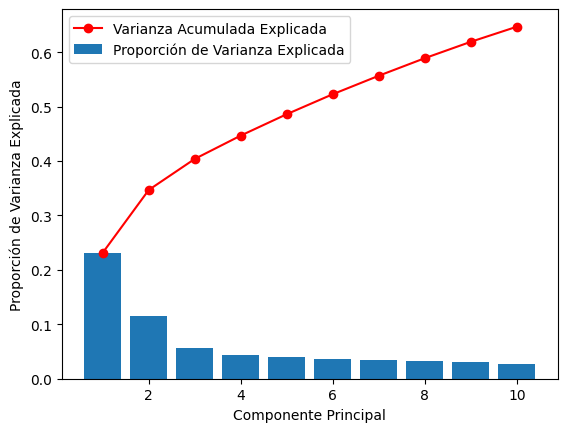

In [ ]:
# VARIANZA ACUMULADA EXPLICADA
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.bar(range(1, n_components + 1), explained_variance_ratio, label='Proporción de Varianza Explicada')
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='-', color='r', label='Varianza Acumulada Explicada')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.legend()
plt.show()

In [ ]:
# ITERACION DE VALIDACION CRUZADA
for train_index, val_index in kf.split(X_pca, y):
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #MODELO RN
    model = keras.Sequential([

    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),

    layers.Dense(32, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])
    # COMPILACION
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # TRAIN
    history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_val, y_val), verbose=0)

    # EVALUCACION
    _, accuracy = model.evaluate(X_val, y_val)
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    conf_matrix = confusion_matrix(y_val, y_pred)
    TN, FP, FN, TP = conf_matrix[0][0], conf_matrix[0][1], conf_matrix[1][0], conf_matrix[1][1]
    recall = TP / max(TP + FN, 1)
    specificity = TN / max(TN + FP, 1)

    # ALMACENAMIENTO DE METRICAS
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    specificity_scores.append(specificity)

178/178 [==============================] - 0s 2ms/step


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                704       
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# PROMEDIO DE METRICAS DE RENDIMIENTO
mean_accuracy = np.mean(accuracy_scores)
mean_recall = np.mean(recall_scores)
mean_specificity = np.mean(specificity_scores)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Recall (Sensibilidad): {mean_recall:.4f}')
print(f'Mean Specificity: {mean_specificity:.4f}')

Mean Accuracy: 0.9552
Mean Recall (Sensibilidad): 0.9553
Mean Specificity: 0.9551


In [ ]:
# ACCURACY SOBRE TEST
accuracy = model.evaluate(X_val, y_val)[1]
print(f'Accuracy on test set: {accuracy}')

178/178 [==============================] - 0s 2ms/step - loss: 0.1165 - accuracy: 0.9531
Accuracy on test set: 0.9530590772628784


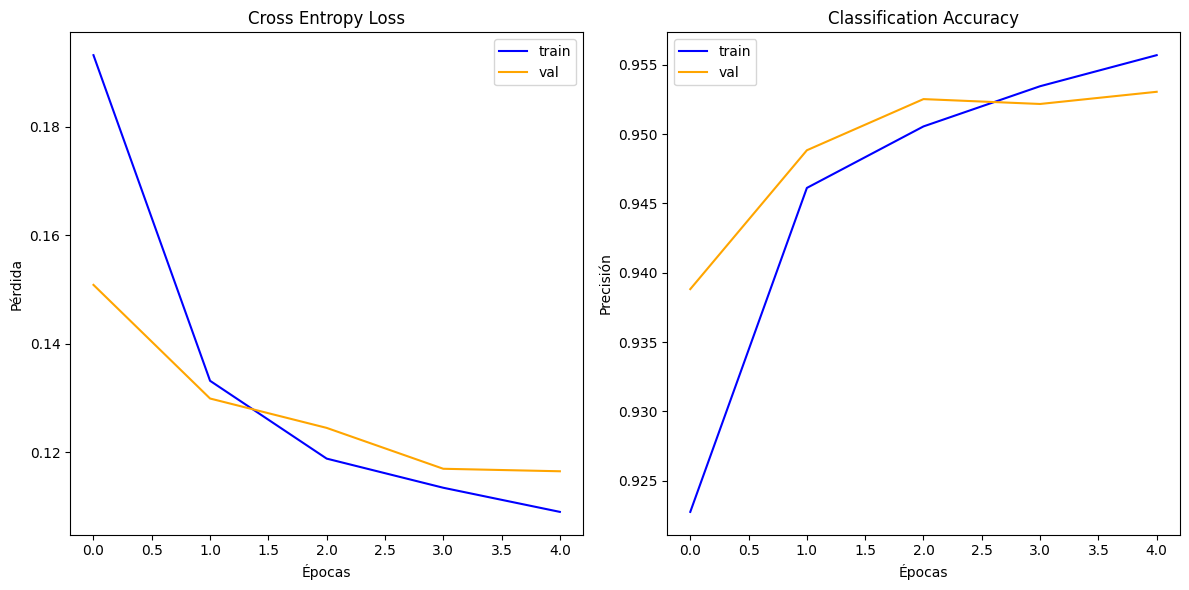

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# LOSS ENTROPY - Grafico
axes[0].set_title('Cross Entropy Loss')
axes[0].plot(history.history['loss'], color='blue', label='train')
axes[0].plot(history.history['val_loss'], color='orange', label='val')
axes[0].legend()
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')

# ACCURACY -Grafico
axes[1].set_title('Classification Accuracy')
axes[1].plot(history.history['accuracy'], color='blue', label='train')
axes[1].plot(history.history['val_accuracy'], color='orange', label='val')
axes[1].legend()
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')

plt.tight_layout()
plt.show()

In [ ]:
#MATRIZ DE CONFUSION
y_pred = (model.predict(X_val) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_val, y_pred)

178/178 [==============================] - 0s 2ms/step


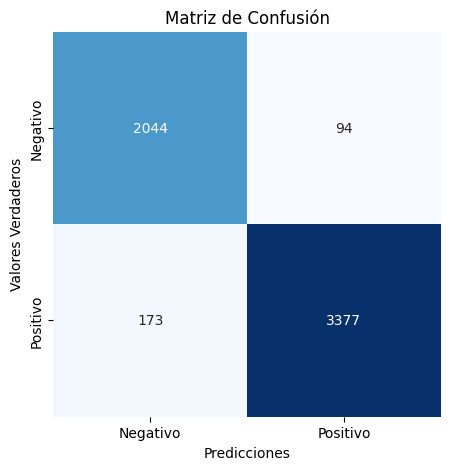

In [ ]:
labels = ['Negativo', 'Positivo']
conf_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
import tensorflow as tf

# Guardar el modelo
model.save('modelo_entrenado.h5')

# Cargar el modelo
modelo_cargado = tf.keras.models.load_model('modelo_entrenado.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
